In [1]:
# Set and import libraries

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Set up the engine for readign sqlite file(s)
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# View keys (i.e., tables) in the existing database
Base.classes.keys()

['measurement', 'station']

In [5]:
# Create and save references to each table
measurement_ref = Base.classes.measurement
station_ref = Base.classes.station

In [6]:
# Create session link
session = Session(engine)

# Exploratory Climate Analysis

In [7]:
#Find the last date in the database

# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(measurement_ref.date).order_by(measurement_ref.date.desc()).first()
last_date[0]

'2017-08-23'

In [8]:
# Calculate the date 1 year ago (i.e., 12 months, or 365 days)
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
query_date

datetime.date(2016, 8, 23)

In [9]:
# Query for date and precipitation
last_12_months = session.query(measurement_ref.date, measurement_ref.prcp).\
    filter(measurement_ref.date >= query_date).all()

In [10]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(last_12_months)
precip_df = precip_df.set_index("date")
precip_df

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [11]:
# Sort the dataframe by date
precip_df = precip_df.sort_values("date")
precip_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


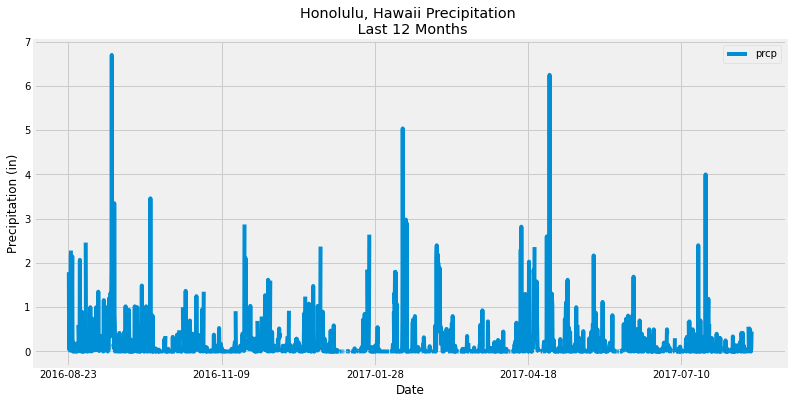

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Honolulu, Hawaii Precipitation \n Last 12 Months")
plt.savefig("images/hon_hawaii_precip_timeseries.jpeg")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

summary_precip_df = precip_df.groupby("date").agg({"prcp": ["mean", "median", "var", "std", "sem"]})
summary_precip_df

prcp                                     
                mean median       var       std       sem
date                                                     
2016-08-23  0.451667  0.100  0.499097  0.706468  0.288414
2016-08-24  1.555000  1.800  0.706510  0.840541  0.343150
2016-08-25  0.077143  0.080  0.005157  0.071813  0.027143
2016-08-26  0.016667  0.015  0.000267  0.016330  0.006667
2016-08-27  0.064000  0.020  0.006680  0.081731  0.036551
...              ...    ...       ...       ...       ...
2017-08-19  0.030000  0.000  0.002700  0.051962  0.030000
2017-08-20  0.005000  0.005  0.000050  0.007071  0.005000
2017-08-21  0.193333  0.020  0.100933  0.317700  0.183424
2017-08-22  0.166667  0.000  0.083333  0.288675  0.166667
2017-08-23  0.132500  0.040  0.046225  0.215000  0.107500

[366 rows x 5 columns]

In [14]:
# Design a query to show how many stations are available in this dataset?
count_stations = session.query(func.count(station_ref.station)).all()
print(f"There are {count_stations[0][0]} unique station IDs.")

There are 9 unique station IDs.


In [15]:
first_row_1 = session.query(station_ref).first()
first_row_1.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1eefb1fdc88>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

In [16]:
# Find the most active stations, group stations and calculate # of measurements
grouped_station_count = session.query(measurement_ref.station, func.count(measurement_ref.station)).group_by(measurement_ref.station).all()
grouped_station_count

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [17]:
# List the stations and the counts in descending order.
ordered_stations = session.query(measurement_ref.station, func.count(measurement_ref.station)).order_by(func.count(measurement_ref.station).desc()).group_by(measurement_ref.station).all()

station_list = []

for station in ordered_stations:
    print(station[0], station[1])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded
min_temp = session.query(func.min(measurement_ref.tobs)).filter(measurement_ref.station == "USC00519281").all()

for temp in min_temp:
    print(f"The lowest temperature recorded was {temp[0]}.")

The lowest temperature recorded was 54.0.


In [19]:
# highest temperature recorded, and average temperature of the most active station?
max_temp = session.query(func.max(measurement_ref.tobs)).filter(measurement_ref.station == "USC00519281").all()

for temp in max_temp:
    print(f"The highest temperature recorded was {temp[0]}.")

The highest temperature recorded was 85.0.


In [20]:
# Choose the station with the highest number of temperature observations.
all_temp_records = session.query(measurement_ref.station, func.count(measurement_ref.tobs)).\
                    order_by(func.count(measurement_ref.tobs).desc()).group_by(measurement_ref.station).first()

all_temp_records

('USC00519281', 2772)

In [21]:
most_temp_recs = session.query(measurement_ref.date, measurement_ref.tobs).filter(measurement_ref.station == 'USC00519281').all()
most_temp_recs

[('2010-01-01', 70.0),
 ('2010-01-02', 62.0),
 ('2010-01-03', 74.0),
 ('2010-01-04', 75.0),
 ('2010-01-05', 74.0),
 ('2010-01-06', 76.0),
 ('2010-01-07', 69.0),
 ('2010-01-08', 66.0),
 ('2010-01-09', 70.0),
 ('2010-01-10', 75.0),
 ('2010-01-11', 64.0),
 ('2010-01-12', 60.0),
 ('2010-01-13', 61.0),
 ('2010-01-14', 68.0),
 ('2010-01-15', 64.0),
 ('2010-01-16', 66.0),
 ('2010-01-17', 67.0),
 ('2010-01-18', 70.0),
 ('2010-01-19', 67.0),
 ('2010-01-20', 67.0),
 ('2010-01-21', 69.0),
 ('2010-01-22', 60.0),
 ('2010-01-23', 75.0),
 ('2010-01-24', 75.0),
 ('2010-01-25', 65.0),
 ('2010-01-26', 75.0),
 ('2010-01-27', 69.0),
 ('2010-01-28', 67.0),
 ('2010-01-29', 66.0),
 ('2010-01-30', 69.0),
 ('2010-01-31', 72.0),
 ('2010-02-01', 67.0),
 ('2010-02-02', 65.0),
 ('2010-02-03', 64.0),
 ('2010-02-04', 67.0),
 ('2010-02-05', 67.0),
 ('2010-02-06', 68.0),
 ('2010-02-07', 69.0),
 ('2010-02-08', 66.0),
 ('2010-02-09', 69.0),
 ('2010-02-10', 61.0),
 ('2010-02-11', 71.0),
 ('2010-02-12', 70.0),
 ('2010-02-

In [22]:
station_USC00519281_df = pd.DataFrame(most_temp_recs)

In [23]:
station_USC00519281_df = station_USC00519281_df.set_index("date")

In [24]:
station_USC00519281_df

,tobs
date,
2010-01-01,70.0
2010-01-02,62.0
2010-01-03,74.0
2010-01-04,75.0
2010-01-05,74.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


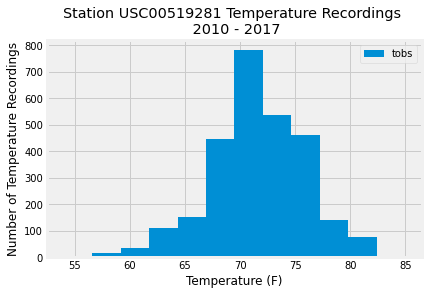

In [25]:
# Plot the results as a histogram
station_USC00519281_df.plot(kind="hist", bins=12)
plt.title("Station USC00519281 Temperature Recordings \n 2010 - 2017")
plt.xlabel("Temperature (F)")
plt.ylabel("Number of Temperature Recordings")
plt.savefig("images/station_USC00519281_temp_recordings.jpeg")

## Bonus Challenge Assignment

### Temperature Analysis I

In [26]:
# Set June and December varibles, i.e., their numbered month
june = "06"
december = "12"

In [27]:
# Query for June and December

june_query = session.query(measurement_ref.tobs).filter(func.strftime("%m", measurement_ref.date) == june).all()
december_query = session.query(measurement_ref.tobs).filter(func.strftime("%m", measurement_ref.date) == december).all()

In [28]:
# Test the output to see if it's correct
june_query

[(78.0),
 (76.0),
 (78.0),
 (76.0),
 (77.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (77.0),
 (77.0),
 (82.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (76.0),
 (78.0),
 (78.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (73.0),
 (70.0),
 (76.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (77.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (75.0),
 (76.0),
 (76.0),
 (77.0),
 (78.0),
 (76.0),
 (77.0),
 (75.0),
 (77.0),
 (76.0),
 (76.0),
 (75.0),
 (77.0),
 (77.0),
 (76.0),
 (78.0),
 (77.0),
 (76.0),
 (77.0),
 (76.0),
 (76.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (77.0),
 (77.0),
 (76.0),
 (75.0),
 (76.0),
 (76.0),
 (77.0),
 (76.0),
 (73.0),
 (73.0),
 (75.0),
 (77.0),
 (76.0),
 (77.0),
 (79.0),
 (78.0),
 (79.0),
 (78.0),
 (78.0),
 (79.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (77.0),
 (78.0),
 (77.0),
 (76.0),
 (78.0),
 (78.0),
 (77.0),
 (78.0),
 (78.0),
 (73.0),
 (76.0),
 (77.0),
 (75.0),
 (76.0),
 (74.0),
 

In [29]:
# Set up the ind t-test
t_test = stats.ttest_ind(june_query, december_query, nan_policy='omit')

In [30]:
# Print the t-test
print(t_test)

Ttest_indResult(statistic=array([31.60372399]), pvalue=array([3.9025129e-191]))


### Findings

The t-stat and p-value both point to the means being different, meaning there is strong evidence that the mean temperatures for June and December are indeed different. 

### Temperature Analysis II

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement_ref.tobs), func.avg(measurement_ref.tobs), func.max(measurement_ref.tobs)).\
        filter(measurement_ref.date >= start_date).filter(measurement_ref.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Calculate this_year and prev_year min, avg, and max temps
this_year = calc_temps('2017-01-01', '2017-01-20')
prev_year = calc_temps('2016-01-01', '2016-01-20')

In [33]:
# Show this_year_list
this_year_list = list(np.ravel(this_year))
this_year_list

[60.0, 69.49180327868852, 81.0]

In [34]:
# Show prev_year_list

prev_year_list = list(np.ravel(prev_year))
prev_year_list

[61.0, 69.34745762711864, 78.0]

In [35]:
# set the error bar and show
this_year_err = (this_year_list[2] - this_year_list[0])
this_year_err

21.0

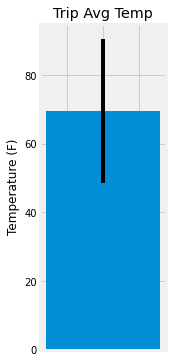

In [36]:
# Plot the results as bar chart
plt.figure(figsize=(2, 6))
plt.bar(1, this_year_list[1])
plt.errorbar(1, this_year_list[1], yerr=this_year_err, color='black')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.savefig("images/trip_avg_temp.jpeg")

In [37]:
# Query for station, name, lat, lon, elevation, and total precipitation by station
prev_year_rain = session.query(measurement_ref.station, station_ref.latitude, station_ref.longitude, station_ref.elevation, func.sum(measurement_ref.prcp)).\
                group_by(measurement_ref.station).\
                filter(measurement_ref.date >= '2016-01-01').filter(measurement_ref.date <= '2016-01-20').filter(station_ref.station == measurement_ref.station).all()

In [38]:
# Print to see if this looks correct
prev_year_rain

[('USC00513117', 21.4234, -157.8015, 14.6, 0.6800000000000002),
 ('USC00514830', 21.5213, -157.8374, 7.0, 0.7900000000000001),
 ('USC00516128', 21.3331, -157.8025, 152.4, 2.95),
 ('USC00517948', 21.3934, -157.9751, 11.9, 0.0),
 ('USC00519281', 21.45167, -157.84888999999998, 32.9, 1.09),
 ('USC00519397', 21.2716, -157.8168, 3.0, 0.24000000000000002),
 ('USC00519523', 21.33556, -157.71139, 19.5, 0.13)]

In [39]:
# Convert to DataFrame, and show DataFrame - Note: casting collumn names fixed an Attribution Error
prev_year_df = pd.DataFrame(prev_year_rain, columns = ["Station", "Lat", "Lon", "Elevation", "Prcp"])
prev_year_df

,Station,Lat,Lon,Elevation,Prcp
0,USC00513117,21.42340,-157.80150,14.6,0.68
1,USC00514830,21.52130,-157.83740,7.0,0.79
2,USC00516128,21.33310,-157.80250,152.4,2.95
3,USC00517948,21.39340,-157.97510,11.9,0.00
4,USC00519281,21.45167,-157.84889,32.9,1.09
5,USC00519397,21.27160,-157.81680,3.0,0.24
6,USC00519523,21.33556,-157.71139,19.5,0.13


In [40]:
# Sort the Values in the DataFrame
prev_year_df = prev_year_df.sort_values("Prcp", ascending=False)

In [41]:
# Set Station as the Index
prev_year_df = prev_year_df.set_index("Station")

In [42]:
# Show the dataframe
prev_year_df 

,Lat,Lon,Elevation,Prcp
Station,,,,
USC00516128,21.33310,-157.80250,152.4,2.95
USC00519281,21.45167,-157.84889,32.9,1.09
USC00514830,21.52130,-157.83740,7.0,0.79
USC00513117,21.42340,-157.80150,14.6,0.68
USC00519397,21.27160,-157.81680,3.0,0.24
USC00519523,21.33556,-157.71139,19.5,0.13
USC00517948,21.39340,-157.97510,11.9,0.00


In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement_ref.tobs), func.avg(measurement_ref.tobs), func.max(measurement_ref.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement_ref.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [44]:
# Set the start and end date of the trip
start_date = dt.date(2016, 1, 1)
end_date = dt.date(2016, 1, 20)

In [45]:
# Use the start and end date to create a range of dates
dates = []
trip_days = []

while start_date <= end_date:
    dates.append(start_date)
    start_date += dt.timedelta(days=1)

# Remove the year and save a list of %m-%d strings
for date in dates:
    change = dt.datetime.strftime(date, "%m-%d")
    trip_days.append(change)
    

In [46]:
# Show trip_days to see if it's correct
trip_days

['01-01',
 '01-02',
 '01-03',
 '01-04',
 '01-05',
 '01-06',
 '01-07',
 '01-08',
 '01-09',
 '01-10',
 '01-11',
 '01-12',
 '01-13',
 '01-14',
 '01-15',
 '01-16',
 '01-17',
 '01-18',
 '01-19',
 '01-20']

In [47]:
# Loop through dates, calculate daily min, daily avg, and daily max for each, and append to dictionary
daily_dict = {}

for date in trip_days:
    daily_calc = daily_normals(f"{date}")
    d_min = daily_calc[0][0]
    d_avg = daily_calc[0][1]
    d_max = daily_calc[0][2]
    daily_dict[f"{date}"] = [d_min, d_avg, d_max]

In [48]:
# Show the dictionary to check it
daily_dict

{'01-01': [62.0, 69.15384615384616, 77.0],
 '01-02': [60.0, 69.39622641509433, 77.0],
 '01-03': [62.0, 68.9090909090909, 77.0],
 '01-04': [58.0, 70.0, 76.0],
 '01-05': [56.0, 67.96428571428571, 76.0],
 '01-06': [61.0, 68.96491228070175, 76.0],
 '01-07': [57.0, 68.54385964912281, 76.0],
 '01-08': [57.0, 67.16071428571429, 75.0],
 '01-09': [58.0, 67.9298245614035, 78.0],
 '01-10': [62.0, 69.74137931034483, 77.0],
 '01-11': [57.0, 67.3103448275862, 78.0],
 '01-12': [57.0, 67.4074074074074, 81.0],
 '01-13': [57.0, 67.25454545454545, 77.0],
 '01-14': [58.0, 69.52631578947368, 77.0],
 '01-15': [56.0, 69.31372549019608, 78.0],
 '01-16': [54.0, 68.62962962962963, 80.0],
 '01-17': [61.0, 69.07407407407408, 76.0],
 '01-18': [57.0, 68.63157894736842, 77.0],
 '01-19': [60.0, 68.26315789473684, 78.0],
 '01-20': [61.0, 68.86666666666666, 78.0]}

In [49]:
# Create DataFrame from the dictionary

daily_df = pd.DataFrame(daily_dict).T

In [50]:
# Rename the columns to be descriptive
daily_df = daily_df.rename(columns={0: "Min Temp", 1: "Avg Temp", 2: "Max Temp"})

In [51]:
# Show the dataframe
daily_df

,Min Temp,Avg Temp,Max Temp
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0
01-10,62.0,69.741379,77.0


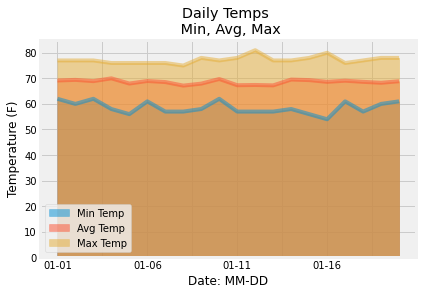

In [55]:
# Plot the findings as an area plot
daily_df.plot(kind="area", stacked=False)
plt.title("Daily Temps \n Min, Avg, Max")
plt.xlabel("Date: MM-DD")
plt.ylabel("Temperature (F)")
plt.savefig("images/daily_temps_area_chart.jpeg")